In [251]:
import warnings

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from utilities import adf_test, kpss_test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

Import dataset into a pandas dataframe, split the dataset into a training/testing set and plot the d
ifferenced series.

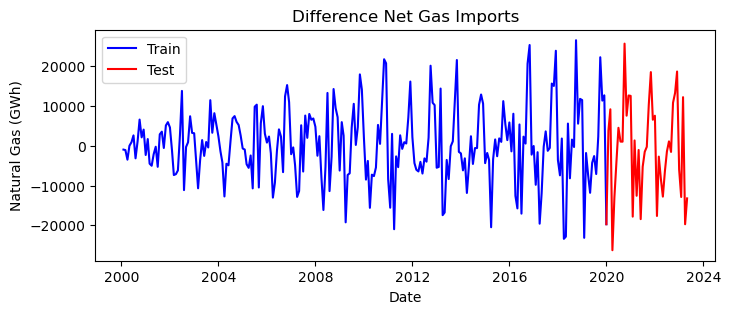

In [72]:
file_path = "./data/overall_natgas_imports_exports_monthly.csv"
df = pd.read_csv(file_path)
df['date']= pd.to_datetime(df["date"], format="%b-%y")
df = df.set_index(["date"])
df = df[["net_imports_GWh"]]
df["net_imports_GWh_diff"] = df["net_imports_GWh"].diff()
df = df.dropna()

train_end = datetime(2020, 1, 1)
df_train, df_test = df[:train_end], df.loc[train_end:]
fig, ax = plt.subplots(1, 1, figsize=(8, 3), sharex=True)
ax.set_title("Difference Net Gas Imports")
ax.plot(df_train.index, df_train["net_imports_GWh_diff"], "b")
ax.plot(df_test.index, df_test["net_imports_GWh_diff"], "r")
ax.set_xlabel("Date")
ax.set_ylabel("Natural Gas (GWh)")
ax.legend(labels=["Train", "Test"])
plt.show()

Confirm stationarity assumption with a Dickey-Fuller and KPSS statistical test.

In [60]:
adf_test(df["net_imports_GWh_diff"])
print("\n")
kpss_test(df["net_imports_GWh_diff"])

Results of Dickey-Fuller Test:
H0 The series has a unit root, H1: The series doesn't no unit root.
Test Statistic                -7.081035e+00
p-value                        4.665871e-10
#Lags Used                     1.200000e+01
Number of Observations Used    2.670000e+02
Critical Value (1%)           -3.455081e+00
Critical Value (5%)           -2.872427e+00
Critical Value (10%)          -2.572571e+00
dtype: float64


Results of KPSS Test:
H0 The process is trend stationary., H1: The series has a unit root.
Test Statistic           0.020038
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Plot the ACF and PACF to see theres a 1 month and 12 month seasonality ACF lag and upto 12 month PACF lag 

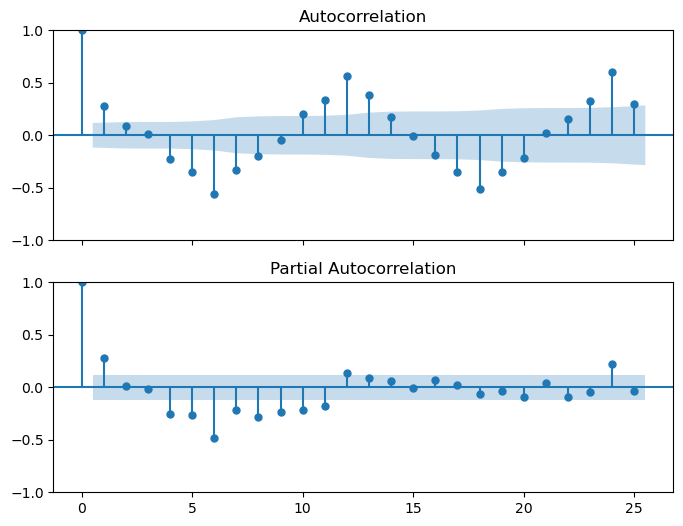

In [241]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
acf = plot_acf(df["net_imports_GWh_diff"], ax=axs[0])
pacf = plot_pacf(df["net_imports_GWh_diff"], ax=axs[1])

Perform SARIMA model fitting using the training dataset.

In [219]:
arima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
sarima_model = SARIMAX(df["net_imports_GWh"], order=arima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(method='bfgs')
sarima_model_fit.summary()

         Current function value: 9.654602
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    net_imports_GWh   No. Observations:                  280
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2703.288
Date:                            Thu, 31 Aug 2023   AIC                           5416.577
Time:                                    14:07:41   BIC                           5434.513
Sample:                                02-01-2000   HQIC                          5423.782
                                     - 05-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5566      0.083      6.667      0.000       0.393       0.720
ma.L1         -0.8989      0.048    -18.777      0.000      -0.993      -0.805
ar.S.L12      -0.1931      0.075     -2.567      0.010      -0.341      -0.046
ma.S.L12      -0.6554      0.062    -10.575      0.000      -0.777      -0.534
sigma2      3.586e+07   6.11e-10   5.86e+16      0.000    3.59e+07    3.59e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 2.61
Prob(Q):                              0.60   Prob(JB):                         0.27
Heteroskedasticity (H):               1.76   Skew:                             0.09
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.73e+32. Standard errors may be unstable.
"""

Assess the models historical accuracy using mean square error on recent dates and also plot the residual series.

MAPE: 0.1670 %


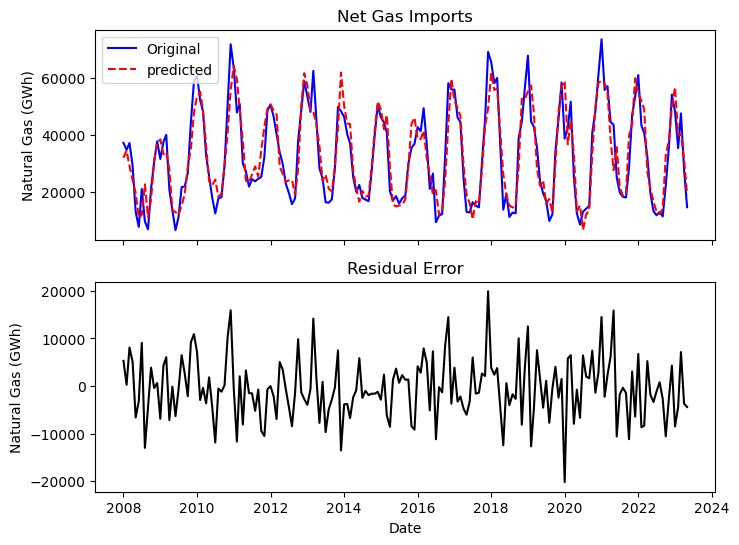

In [250]:
from_date = datetime(2008, 1, 1)
predictions = sarima_model_fit.predict()
predictions = predictions.loc[from_date:]
df_tmp = df.loc[from_date:]
mape = mean_absolute_percentage_error(predictions.values, df_tmp["net_imports_GWh"].values)

print("MAPE: {:.4f} %".format(mape))
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
axs[0].set_title("Net Gas Imports")
axs[0].set_ylabel("Natural Gas (GWh)")
axs[0].plot(df_tmp.index, df_tmp["net_imports_GWh"], "b")
axs[0].plot(predictions.index, predictions, "r--")
axs[0].legend(labels=["Original", "predicted"], loc="upper left")
axs[1].plot(sarima_model_fit.resid[from_date:], "k")
axs[1].set_title("Residual Error")
axs[1].set_ylabel("Natural Gas (GWh)")
axs[1].set_xlabel("Date")
plt.show()

As residuals appear heteroskedastic i.e. variance is changing in time we can combine SARIMA with GARCH model. First check the ACF and PACF of the resiudals to get the GARCH model order.

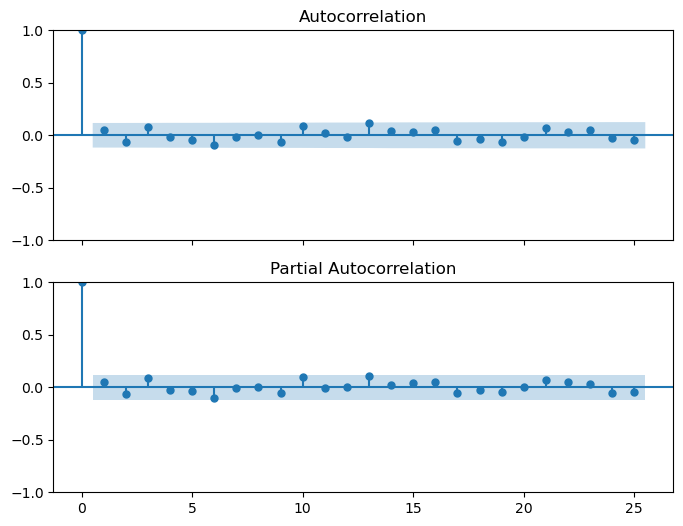

In [257]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
acf = plot_acf(sarima_model_fit.resid, ax=axs[0])
pacf = plot_pacf(sarima_model_fit.resid, ax=axs[1])
plt.show()

Fit the GARCH model with and check for coefficient significance in the fit summary then plot the time series variance change overtime.

In [283]:
garch_model = arch_model(sarima_model_fit.resid, vol='GARCH', p=12, q=1)
garch_model_fit = garch_model.fit(disp=False)
print(garch_model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2829.00
Distribution:                  Normal   AIC:                           5688.00
Method:            Maximum Likelihood   BIC:                           5742.52
                                        No. Observations:                  280
Date:                Thu, Aug 31 2023   Df Residuals:                      279
Time:                        14:40:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             5.5983    676.954  8.270e-03      0.993 